# IPS（SNIPS）・DR（SNDR）推定により効果検証を行う

## モジュールインポート

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor

## データ生成

In [265]:
# 再現性のためのシード
np.random.seed(42)

# サンプルサイズ
n = 100_000

# --- 共変量の生成 ---
X1 = np.random.normal(loc=50, scale=10, size=n).astype(int)  # age
X2_raw = np.random.choice(['male', 'female'], size=n)        # gender (文字列)
X3 = np.random.normal(loc=500, scale=100, size=n).astype(int)  # income

# gender を数値に変換（male=1, female=0）
le = LabelEncoder()
X2 = le.fit_transform(X2_raw)

# --- 傾向スコアの計算（バイアスあり） ---
def sigmoid(x): return 1 / (1 + np.exp(-x))

logit = -7 + 0.05 * X1 + 1.0 * X2 + 0.005 * X3
pscore = sigmoid(logit)
T = np.random.binomial(1, pscore)

# --- アウトカム生成 ---
base_outcome = 0.3 * X1 + 5 * X2 + 0.1 * X3
treatment_effect = 20 + X3 / 50 + np.random.normal(0, 10, n)

Y0 = base_outcome + np.random.normal(0, 10, n)
Y1 = base_outcome + treatment_effect + np.random.normal(0, 10, n)

# 観測アウトカム
Y = T * Y1 + (1 - T) * Y0

# --- データフレーム作成 ---
df = pd.DataFrame({
    'id': np.arange(1, n + 1),
    'X1': X1,        # age
    'X2': X2,        # gender (encoded)
    'X3': X3,        # income
    'T': T,          # treatment
    'Y0': Y0,        # 潜在outcome (control)
    'Y1': Y1,        # 潜在outcome (treatment)
    'Y': Y           # 観測されたoutcome
})

# --- 確認表示 ---
display(df.head())
display(df.groupby('T').count())
display(df.groupby('T').mean())

,id,X1,X2,X3,T,Y0,Y1,Y
0,1,54,0,618,0,76.184656,111.568310,76.184656
1,2,48,0,488,0,64.510831,99.271449,64.510831
2,3,56,0,440,0,55.110721,79.751912,55.110721
3,4,65,1,474,1,74.232740,117.408524,117.408524
4,5,47,0,496,0,55.383779,93.780996,55.383779


,id,X1,X2,X3,Y0,Y1,Y
T,,,,,,,
0,79326,79326,79326,79326,79326,79326,79326
1,20674,20674,20674,20674,20674,20674,20674


,id,X1,X2,X3,Y0,Y1,Y
T,,,,,,,
0,49944.631294,48.576141,0.452399,490.136210,65.788873,95.723969,65.788873
1,50214.867853,53.086872,0.673406,535.204121,72.816858,103.229331,103.229331


In [266]:
real_att = (df[df['T']==1]['Y1'] - df[df['T']==1]['Y0']).mean()
real_att

30.412473152177245

In [272]:
real_ate = (df['Y1'] - df['Y0']).mean()
real_ate

30.033788966718525

In [273]:
naive_att = df[df['T']==1]['Y'].mean() - df[df['T']==0]['Y'].mean()
naive_att

37.44045866696089

In [274]:
X_ps = df[['X1', 'X2', 'X3']]
y_ps = df['T']

ps_model = LogisticRegression()
ps_model.fit(X_ps, y_ps)
df['propensity_score'] = ps_model.predict_proba(X_ps)[:, 1]
df

,id,X1,X2,X3,T,Y0,Y1,Y,propensity_score
0,1,54,0,618,0,76.184656,111.568310,76.184656,0.229650
1,2,48,0,488,0,64.510831,99.271449,64.510831,0.102255
2,3,56,0,440,0,55.110721,79.751912,55.110721,0.117928
3,4,65,1,474,1,74.232740,117.408524,117.408524,0.401596
4,5,47,0,496,0,55.383779,93.780996,55.383779,0.101352
...,...,...,...,...,...,...,...,...,...
99995,99996,47,0,634,0,96.952284,98.274843,96.952284,0.185073
99996,99997,44,1,656,1,77.465829,113.953364,113.953364,0.369274
99997,99998,54,1,340,0,39.363520,92.791172,39.363520,0.163348
99998,99999,47,0,459,0,65.579429,95.037261,65.579429,0.085492


<Axes: >

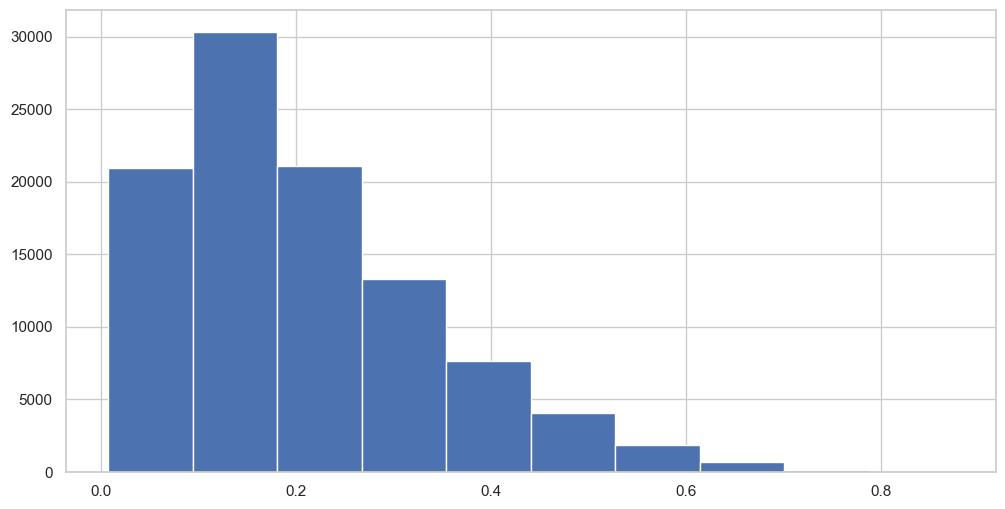

In [275]:
df['propensity_score'].hist()

In [282]:
# IPS
T = df['T']
Y = df['Y']
e = df['propensity_score']
ips_att = df[df['T']==1]['Y'].mean() - (((((1-T)*e) / (1-e)) * Y).sum() / (((1-T)*e) / (1-e)).sum())
ips_att

30.453154286582148

In [224]:
# SNIPS
snips_att = ((T * (w * Y)).sum() / (T * w).sum()) - (((1-T) * (w * Y)).sum() / ((1-T) * w).sum())
snips_att

24.903163512847044

In [257]:
# DR
# 処置フラグと報酬
X = df[['X1', 'X2', 'X3']]

# モデル（treatment=0用）
model_cr = RandomForestRegressor()
model_cr.fit(X[T == 0], Y[T == 0])

# モデル（treatment=1用）
model_tr = RandomForestRegressor()
model_tr.fit(X[T == 1], Y[T == 1])

# 各個体について μ0, μ1 の予測値
mu0_hat = model_cr.predict(X)
mu1_hat = model_tr.predict(X)

# データフレームに追加（後で DR に使える）
df['mu0_hat'] = mu0_hat
df['mu1_hat'] = mu1_hat
df['mu_hat'] = T * mu1_hat + (1-T) * mu0_hat
mu_hat = df['mu_hat']
df

,id,X1,X2,X3,T,Y0,Y1,Y,propensity_score,mu0_hat,mu1_hat,mu_hat
0,1,54,0,618,0,76.184656,105.388310,76.184656,0.229650,74.208818,106.104831,74.208818
1,2,48,0,488,0,64.510831,94.391449,64.510831,0.102255,63.210789,78.390282,63.210789
2,3,56,0,440,0,55.110721,75.351912,55.110721,0.117928,54.188681,86.390287,54.188681
3,4,65,1,474,1,74.232740,112.668524,112.668524,0.401596,81.793330,99.522500,99.522500
4,5,47,0,496,0,55.383779,88.820996,55.383779,0.101352,65.389840,89.869606,65.389840
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,47,0,634,0,96.952284,91.934843,96.952284,0.185073,86.139889,96.813436,86.139889
99996,99997,44,1,656,1,77.465829,107.393364,107.393364,0.369274,85.025995,106.056946,106.056946
99997,99998,54,1,340,0,39.363520,89.391172,39.363520,0.163348,52.295406,78.428576,52.295406
99998,99999,47,0,459,0,65.579429,90.447261,65.579429,0.085492,66.110174,77.700478,66.110174


In [258]:
# DR推定
w1 = 1 / e
w0 = (1 / (1-e))
dr_y = (T*mu_hat).mean() + (w1 * T * (Y-mu_hat)).mean()
dr_y_0 = ((1-T)*mu_hat).mean() + (w0 * (1-T) * (Y-mu_hat)).mean()
dr_y - dr_y_0

-31.968472612690434

In [260]:
df.groupby('T').mean(numeric_only=True)[['mu_hat']]

,mu_hat
T,
0,65.791178
1,97.885194


In [109]:
# 傾向スコア推定（sale_flag ~ age + gender + income）
df['gender_encoded'] = LabelEncoder().fit_transform(df['gender'])
X_ps = df[['age', 'gender_encoded', 'income']]
y_ps = df['sale_flag']

ps_model = LogisticRegression()
ps_model.fit(X_ps, y_ps)
df['propensity_score'] = ps_model.predict_proba(X_ps)[:, 1]

In [110]:
# 傾向スコア予測（確率 → 0 or 1）
y_pred_label = model.predict(X)
y_pred_prob = model.predict_proba(X)[:, 1]

# 指標の計算
accuracy = accuracy_score(y, y_pred_label)
recall = recall_score(y, y_pred_label)
roc_auc = roc_auc_score(y, y_pred_prob)

print(f"📊 傾向スコアモデルの性能")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")

📊 傾向スコアモデルの性能
Accuracy  : 0.6775
Recall    : 0.9279
ROC-AUC   : 0.6570


In [113]:
# アウトカムモデル（outcome ~ age + gender + income + sale_flag）
X_outcome = pd.concat([X_ps, df[['sale_flag']]], axis=1)
y_outcome = df['outcome']
outcome_model = LinearRegression()
outcome_model.fit(X_outcome, y_outcome)
mu_hat = outcome_model.predict(X_outcome)

# DR推定量を計算
ps = df['propensity_score']
t = df['sale_flag']
y = df['outcome']

df['dr_estimate'] = ((t - ps) / (ps * (1 - ps))) * (y - mu_hat) + mu_hat

In [114]:
# 傾向スコア帯（10分位）を作成
df['ps_band'] = pd.cut(df['propensity_score'], bins=np.linspace(0, 1, 11), include_lowest=True)

# DR推定量を層別に平均
dr_summary = df.groupby('ps_band')['dr_estimate'].mean().reset_index(name='dr_effect')

dr_summary

,ps_band,dr_effect
0,"(-0.001, 0.1]",NaN
1,"(0.1, 0.2]",-31.682427
2,"(0.2, 0.3]",38.902883
3,"(0.3, 0.4]",104.604110
4,"(0.4, 0.5]",163.888298
5,"(0.5, 0.6]",229.158251
6,"(0.6, 0.7]",297.807940
7,"(0.7, 0.8]",362.982546
8,"(0.8, 0.9]",435.828135
9,"(0.9, 1.0]",515.279455


In [119]:
grouped

count        outcome_mean                 dr_mean            
sale_flag         0      1            0           1           0           1
ps_band                                                                    
(-0.001, 0.1]     0      0          NaN         NaN         NaN         NaN
(0.1, 0.2]        8      2    43.615562  320.403303  -90.217027  202.455973
(0.2, 0.3]      113     49    45.412776  331.667674  -60.680564  268.554505
(0.3, 0.4]      755    448    52.521542  351.663630  -22.333359  318.527747
(0.4, 0.5]     2315   1885    56.615350  370.475127    9.204357  353.858230
(0.5, 0.6]     4143   5097    61.150682  392.141112   36.908044  385.425194
(0.6, 0.7]     4938   9439    65.971064  413.362399   79.522420  412.003713
(0.7, 0.8]     3584  10691    71.519273  435.406481  143.756761  436.474756
(0.8, 0.9]     1047   5240    77.743101  463.810530  285.383607  465.888330
(0.9, 1.0]       27    219    85.582424  500.352034  620.227995  502.340594

In [120]:
# 傾向スコア帯（0.1幅, 10分位）
df['ps_band'] = pd.cut(df['propensity_score'], bins=np.linspace(0, 1, 11), include_lowest=True)

# sale_flag == 1 → treated, 0 → control としてグループ化
grouped = df.groupby(['ps_band', 'sale_flag']).agg(
    count=('id', 'count'),
    outcome_mean=('outcome', 'mean'),
    dr_mean=('dr_estimate', 'mean')
).unstack(fill_value=0)

# 列名をわかりやすく
summary_df = pd.DataFrame({
    'treated_count': grouped['count'][1],
    'control_count': grouped['count'][0],
    'treated_outcome_mean': grouped['outcome_mean'][1],
    'control_outcome_mean': grouped['outcome_mean'][0],
    'treated_dr_estimate_mean': grouped['dr_mean'][1],
    'control_dr_estimate_mean': grouped['dr_mean'][0]
}).reset_index()

# 不要な行を除去（treated/control どちらかが0 or NaN）
summary_df = summary_df.dropna()
summary_df = summary_df[(summary_df['treated_count'] > 0) & (summary_df['control_count'] > 0)]
summary_df

,ps_band,treated_count,control_count,treated_outcome_mean,control_outcome_mean,treated_dr_estimate_mean,control_dr_estimate_mean
1,"(0.1, 0.2]",2,8,320.403303,43.615562,202.455973,-90.217027
2,"(0.2, 0.3]",49,113,331.667674,45.412776,268.554505,-60.680564
3,"(0.3, 0.4]",448,755,351.663630,52.521542,318.527747,-22.333359
4,"(0.4, 0.5]",1885,2315,370.475127,56.615350,353.858230,9.204357
5,"(0.5, 0.6]",5097,4143,392.141112,61.150682,385.425194,36.908044
6,"(0.6, 0.7]",9439,4938,413.362399,65.971064,412.003713,79.522420
7,"(0.7, 0.8]",10691,3584,435.406481,71.519273,436.474756,143.756761
8,"(0.8, 0.9]",5240,1047,463.810530,77.743101,465.888330,285.383607
9,"(0.9, 1.0]",219,27,500.352034,85.582424,502.340594,620.227995


In [123]:
summary_df['estimated_att'] = summary_df['treated_outcome_mean'] - summary_df['control_outcome_mean']
summary_df['estimated_tt'] = summary_df['estimated_att'] * summary_df['treated_count']
summary_df['estimated_tt'].sum() / summary_df['treated_count'].sum()

354.1110511479904

In [124]:
summary_df['estimated_att_dr'] = summary_df['treated_dr_estimate_mean'] - summary_df['control_dr_estimate_mean']
summary_df['estimated_tt_dr'] = summary_df['estimated_att_dr'] * summary_df['treated_count']
summary_df['estimated_tt_dr'].sum() / summary_df['treated_count'].sum()

295.8347298029084